In [1]:
%matplotlib inline

import scipy.io as sio
from pyleoclim import Spectral

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


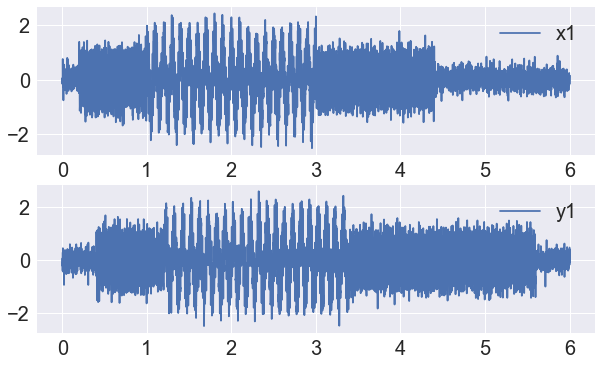

In [2]:
data = sio.loadmat('./wtc_test_data.mat')
x1 = data['x1'][0]
y1 = data['y1'][0]
t = data['t'][0]

sns.set(style="darkgrid", font_scale=2)
fig = plt.figure(figsize=[10, 6])
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t, x1, label='x1')
ax1.legend()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t, y1, label='y1')
ax2.legend()

## First we use the same frequency and timeshift vectors as those in the MATLAB benchmark

MATLAB benchmark: https://www.mathworks.com/help/wavelet/examples/compare-time-frequency-content-in-signals-with-wavelet-coherence.html

In [3]:
tau = np.linspace(np.min(t), np.max(t), np.size(t))
s0 = 2*np.median(np.diff(t))
nv = 12
a0 = 2**(1/nv)
noct = np.floor(np.log2(np.size(t)))-1
scale = s0*a0**(np.arange(noct*nv+1))
freqs = 1/scale[::-1]
res_xwc = Spectral.xwc(
    x1, t, y1, t, tau=tau, nMC=0, freqs=freqs
)

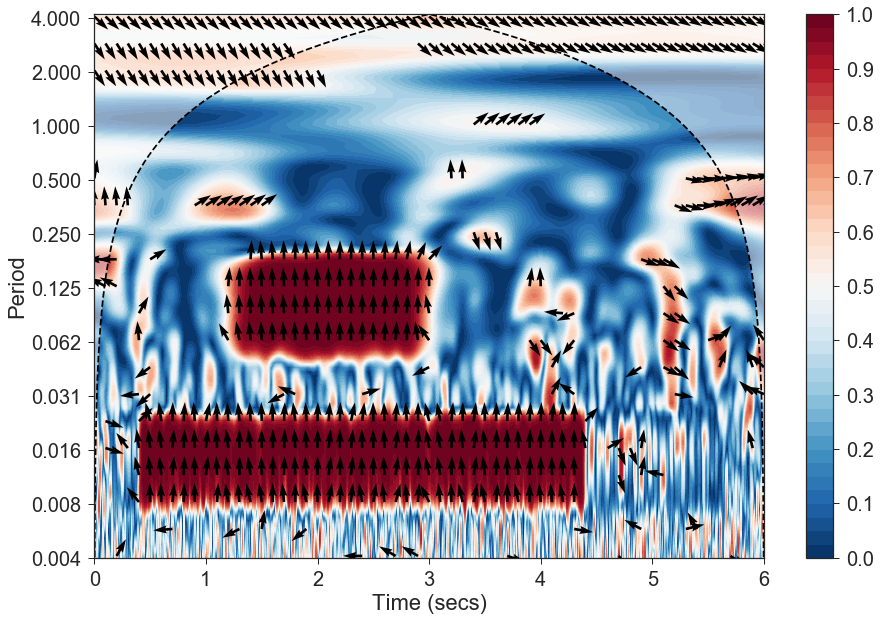

In [4]:
period_ticks = [1/256, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]
ax = Spectral.plot_coherence(res_xwc, figsize=[15, 10],
                             levels=np.linspace(0, 1., 41),
                             tick_range=np.linspace(0, 1., 11),
                             clr_map='RdBu_r',
                             yticks=period_ticks,
                             ylim=[np.min(period_ticks), np.max(res_xwc.coi)],
                             xlabel='Time (secs)',
                             plot_cone=True,
                             plot_signif=False,
                             # adjust arrows
                             skip_x=100,
                             skip_y=6,
                             scale=35,
                             width=0.004
                            )

Now load the result from MATLAB and check the difference between the MATLAB version and our Python version.

In [6]:
data = sio.loadmat('./wtc_result_data.mat')
wcoh = data['wcoh'].T

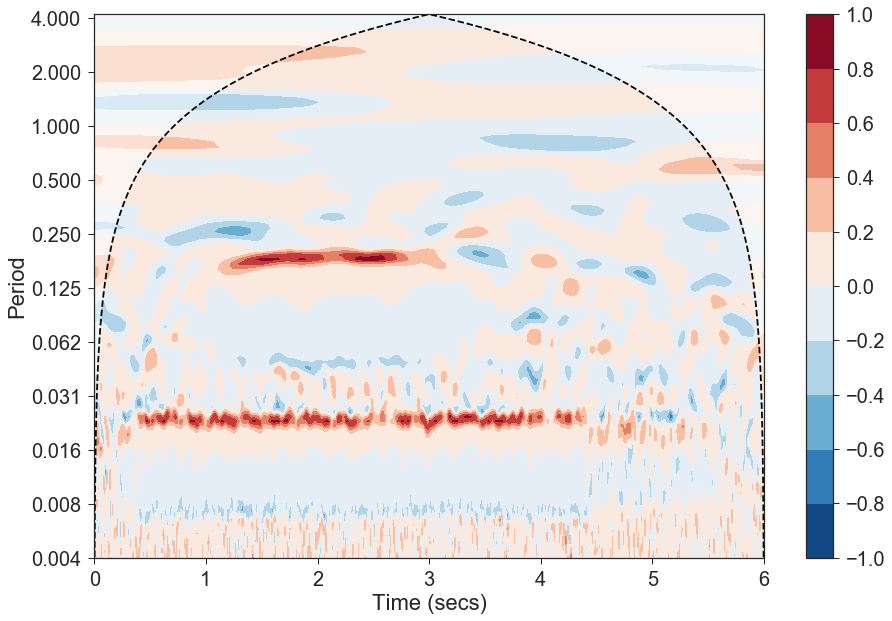

In [7]:
import collections

Results = collections.namedtuple('Results',
                                 ['xw_coherence',
                                  'xw_amplitude',
                                  'xw_phase',
                                  'freqs',
                                  'tau',
                                  'AR1_q',
                                  'coi'])

period_ticks = [1/256, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]
new_res = Results(xw_coherence=res_xwc.xw_coherence-wcoh[:,::-1], xw_amplitude=np.sqrt(np.abs(wcoh)),
                  xw_phase=res_xwc.xw_phase, freqs=freqs, tau=tau,
                  AR1_q=res_xwc.AR1_q, coi=res_xwc.coi)
ax = Spectral.plot_coherence(new_res, figsize=[15, 10],
                             levels=np.linspace(-1, 1, 11),
                             tick_range=np.linspace(-1, 1, 11),
                             clr_map='RdBu_r',
                             yticks=period_ticks,
                             ylim=[np.min(period_ticks), np.max(res_xwc.coi)],
                             xlabel='Time (secs)',
                             plot_cone=True,
                             plot_signif=False,
                             # adjust arrows
                             skip_x=100000,
                             skip_y=100000,
                             scale=35,
                             width=0.004
                            )

Sources of difference:
+ We are using different wavelet methods
+ Smoothing function being used is not exactly the same.

Let's check the distribution of the differences below.

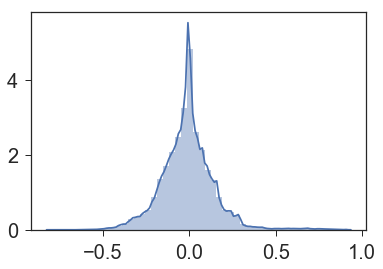

In [8]:
delta = res_xwc.xw_coherence-wcoh[:,::-1]
import seaborn as sns
sns.distplot(delta.flatten())

## Now let's check another example with climate data

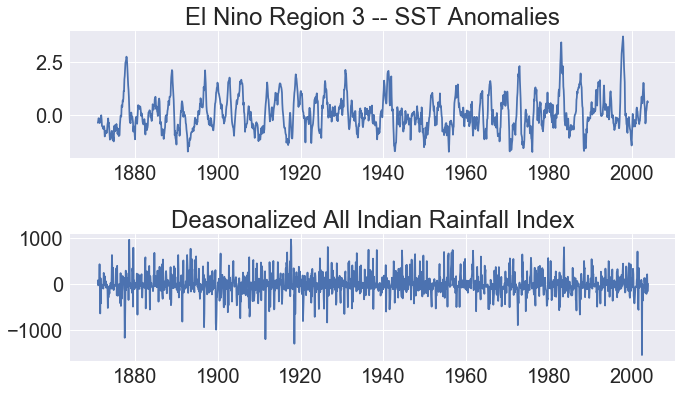

In [9]:
data = sio.loadmat('./wtc_test_data_nino.mat')
air = data['air'][:, 0]
nino = data['nino'][:, 0]
t = data['datayear'][:, 0]
sns.set(style="darkgrid", font_scale=2)

fig = plt.figure(figsize=[10, 6])
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t, nino)
ax1.set_title('El Nino Region 3 -- SST Anomalies')
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t, air)
ax2.set_title('Deasonalized All Indian Rainfall Index')
fig.tight_layout()

In [10]:
tau = np.linspace(np.min(t), np.max(t), 201)
scale = np.logspace(-2, 7, num=51, base=2)
freqs = 1/scale[::-1]

res_xwc = Spectral.xwc(
    nino, t, air, t, tau=tau, nMC=0, freqs=freqs,
#     smooth_factor=0.025 # the larger, the smoother
)

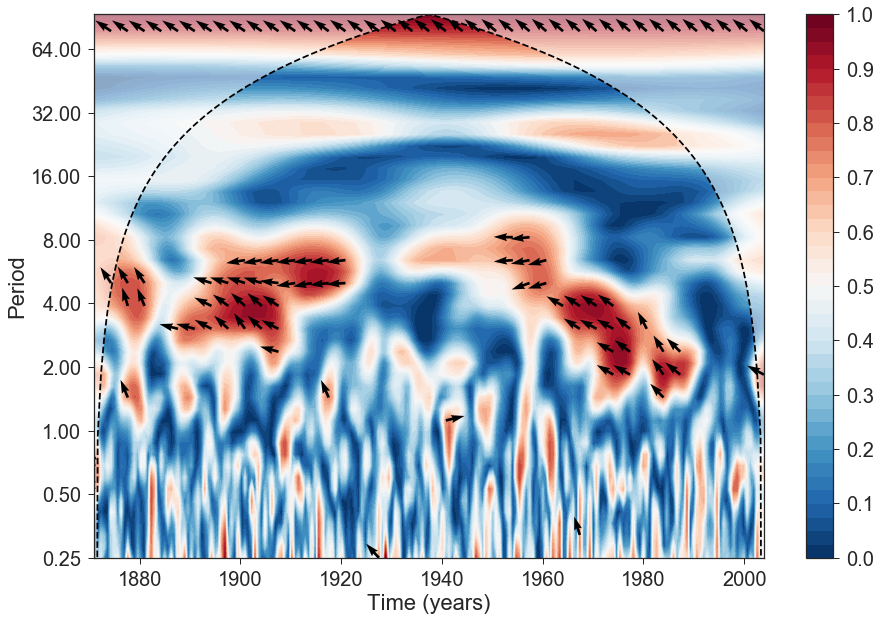

In [11]:
period_ticks = [1/4, 1/2, 1, 2, 4, 8, 16, 32, 64]
ax = Spectral.plot_coherence(res_xwc, figsize=[15, 10],
                             levels=np.linspace(0, 1., 41),
                             tick_range=np.linspace(0, 1., 11),
                             clr_map='RdBu_r',
                             yticks=period_ticks,
                             ylim=[np.min(period_ticks), np.max(res_xwc.coi)],
                             xlabel='Time (years)',
                             plot_cone=True,
                             plot_signif=False,
                             # adjust arrows
                             skip_x=5,
                             skip_y=2,
                             scale=35,
                             width=0.004,
                             pt=0.7 # plot arrow when coherence >= 0.7
                            )